#### Paquetes necesarios

In [21]:
import cv2  
import math 
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output 
import re

In [22]:
def plate_validation(plate):
    # Definir el patrón de la matrícula "0000 AAA"
    plate_pattern = re.compile(r'^\d{4}\s[A-Z]{3}$')

    if plate_pattern.match(plate):
        # La matrícula cumple con el formato
        return plate
    else:
        # La matrícula no cumple con el formato, intentar corregirla
        plate_refactored = re.sub(r'^\s*.*?(\d{4}\s[A-Z]{3}).*$', r'\1', plate)
        return plate_refactored


0: 448x640 1 plate, 89.2ms
Speed: 4.0ms preprocess, 89.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 plate, 92.8ms
Speed: 2.0ms preprocess, 92.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


tensor(826.4053) tensor(471.3972) tensor(934.9300) tensor(505.7900)

[+] MATRÍCULA DETECTADA: 3488 LPZ



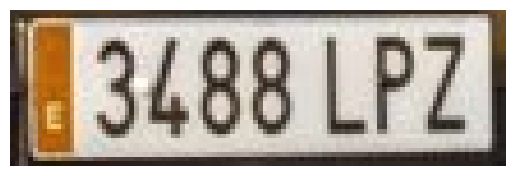

In [33]:
model_car = YOLO('plates_model.pt')
# Guardamos la ruta absoluta de tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

# Guardamos imagen en variable
coche = cv2.imread("Images/coche6.jpg")

results_cars = model_car(coche)

# print(results_cars)

# Detectar coches
results_cars = model_car(coche)

# Para cada detección de coche
for r_car in results_cars:
    boxes_car = r_car.boxes

    for box_car in boxes_car:
        # Coordenadas del cuadro del coche
        x1_car, y1_car, x2_car, y2_car = box_car.xyxy[0]

        print(x1_car, y1_car, x2_car, y2_car)
    

        license_plate_region = coche[int(y1_car):int(y2_car), int(x1_car):int(x2_car)]

        text = pytesseract.image_to_string(license_plate_region, config='--psm 8', output_type=Output.STRING)

        text = plate_validation(text)

        print("\n[+] MATRÍCULA DETECTADA:", text)

        plt.axis("off")
        plt.imshow(license_plate_region) 
        plt.show()

#### Tarea 1: Reconocimiento de matrículas básico

In [1]:
import pytesseract
from pytesseract import Output 
import numpy as np
import cv2  
import math 
from ultralytics import YOLO

# Previamente debes descargar los ejecutables
# Si la ruta de Tesseract no está en el PATH, ruta al ejecutable
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

model_car = YOLO('yolov8n.pt')

# Guardamos imagen en variable
coche = cv2.imread("coche3.jpeg")

plates = []

# Detectar coches
results_cars = model_car(coche)

# Para cada detección de coche
for r_car in results_cars:
    boxes_car = r_car.boxes

    for box_car in boxes_car:
        # Coordenadas del cuadro del coche
        x1_car, y1_car, x2_car, y2_car = box_car.xyxy[0]

        # Definir la región inferior para buscar matrículas
        roi_bottom = coche[int((y1_car + y2_car) / 2):int(y2_car), int(x1_car):int(x2_car)]

        # Convertir la región a escala de grises
        gray_roi_bottom = cv2.cvtColor(roi_bottom, cv2.COLOR_BGR2GRAY)

        # Aplicar umbralización adaptativa
        _, thresh = cv2.threshold(gray_roi_bottom, 127, 255, cv2.THRESH_BINARY)

        cv2.imshow('Thresh', thresh)

        # Buscar contornos en la región inferior
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filtrar contornos
        for contour in contours:
            # Filtrar por área del contorno
            area = cv2.contourArea(contour)
            if 500 < area < 5000:  # Ajusta estos valores según tu caso

                # Aproximación de polígono para evaluar la forma
                epsilon = 0.02 * cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, epsilon, True)

                # Filtrar por la relación de aspecto y la forma
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w) / h
                if 2 < aspect_ratio < 5 and len(approx) >=4:
                    # Ajustar las coordenadas al espacio global de la imagen
                    x, y, w, h = int(x + x1_car), int(y + (y1_car + y2_car) / 2), int(w), int(h)

                    # Extraer la región de la matrícula como una nueva imagen
                    license_plate_region = coche[y:y + h, x+10:x + w]
                    # Aplicar pytesseract a la región de la matrícula
                    text = pytesseract.image_to_string(license_plate_region, config='--psm 8', output_type=Output.STRING)

                    if text in plates:
                        continue

                    print("Matrícula:", text)


                    plates.append(text)

                    # Dibujar cuadro alrededor del contorno
                    cv2.rectangle(coche, (x, y), (x + w, y + h), (0, 255, 0), 3)
                    cv2.imshow('Matrícula', license_plate_region)
                    
                            

# Muestra la imagen con las detecciones
cv2.imshow('Vid', coche)
cv2.waitKey(0)
cv2.destroyAllWindows()



0: 384x640 1 car, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 10.2ms postprocess per image at shape (1, 3, 384, 640)


Matrícula: YL eg Cae

Matrícula: ES

Matrícula: Sern

Matrícula: 202 AP

Matrícula: >

